# [Khawaja Muhammad Owais](https://owais.qzz.io/)

i211762

# Assignment No.01
- Course: Deep learning for perception
- Section: DS-B
- Instructor: Dr. Qurat Ul Ain
- Submitted By: [Khawaja Muhammad Owais](https://owais.qzz.io/)
- i211762

# **Implementation:**

## **Core imports for diffrnt libs**

In [15]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import os
from PIL import Image
from pathlib import Path
import time
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, confusion_matrix


## **configuration parameters for notebook**

In [ ]:
# Setting random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Configuration
class Config:
    BASE_PATH = "/content/drive/MyDrive/Dataset"
    IMG_SIZE = (224, 224)
    BATCH_SIZE = 32
    EPOCHS = 30
    FINE_TUNE_EPOCHS = 10
    VALIDATION_SPLIT = 0.15
    TEST_SPLIT = 0.15
    MAX_SAMPLES = 1000

config = Config()

## **Data Loader Class**

In [ ]:
class AffectDatasetLoader:
    """
    Modular data loader that handles specific structure of the affect dataset.
    Each sample has separate .npy files for expressions, valence, arousal, and landmarks.
    """

    def __init__(self, base_path, img_size=(224, 224)):
        self.base_path = Path(base_path)
        self.annotations_path = self.base_path / "annotations"
        self.images_path = self.base_path / "images"
        self.img_size = img_size
        self.expression_labels = ['Neutral', 'Happy', 'Sad', 'Surprise', 'Fear', 'Disgust', 'Anger', 'Contempt']

    def load_annotation_groups(self, max_samples=None):
        """
        Step 1: Load and group annotation files by their prefixes
        Returns dictionary with grouped annotations
        """
        print("📂 Loading annotation files...")
        npy_files = list(self.annotations_path.glob("*.npy"))
        file_groups = {}

        for file_path in npy_files:
            parts = file_path.stem.split('_')
            if len(parts) == 2:
                prefix, file_type = parts
                if prefix not in file_groups:
                    file_groups[prefix] = {'prefix': prefix}
                file_groups[prefix][file_type] = np.load(file_path, allow_pickle=True)

        # Limit samples if specified
        if max_samples:
            file_groups = dict(list(file_groups.items())[:max_samples])

        print(f"✅ Loaded {len(file_groups)} annotation groups")
        return file_groups

    def parse_samples(self, file_groups):
        """
        Step 2: Parse annotation groups into sample dictionaries
        Validates and extracts expression, valence, arousal values
        """
        print("🔍 Parsing samples...")
        samples = []

        for prefix, annotations in file_groups.items():
            try:
                # Find corresponding image
                image_files = list(self.images_path.glob(f"{prefix}.*"))
                if not image_files:
                    continue

                image_path = image_files[0]
                sample = {'image_path': image_path, 'prefix': prefix}

                # Extract annotation values
                for ann_type in ['exp', 'val', 'aro']:
                    if ann_type in annotations:
                        data = annotations[ann_type]
                        value = data.item() if hasattr(data, 'ndim') and data.ndim == 0 else data[0]

                        if ann_type == 'exp':
                            sample['expression'] = int(value)
                        elif ann_type == 'val':
                            sample['valence'] = float(value)
                        else:
                            sample['arousal'] = float(value)

                # Validate sample has all required annotations
                if all(key in sample for key in ['expression', 'valence', 'arousal']):
                    if sample['valence'] != -2 and sample['arousal'] != -2:  # Filter invalid
                        samples.append(sample)

            except Exception as e:
                continue

        print(f"✅ Parsed {len(samples)} valid samples")
        return samples

    def load_images(self, samples, batch_size=1000):
        """
        Step 3: Load and preprocess images in batches to manage memory
        Returns numpy arrays for images and annotations
        """
        print("🖼️ Loading images...")
        images, expressions, valence_vals, arousal_vals = [], [], [], []

        for i in range(0, len(samples), batch_size):
            batch_samples = samples[i:i + batch_size]

            for sample in batch_samples:
                try:
                    img = Image.open(sample['image_path'])
                    img = img.convert('RGB')
                    img = img.resize(self.img_size)
                    img_array = np.array(img) / 255.0  # Normalize to [0,1]

                    images.append(img_array)
                    expressions.append(sample['expression'])
                    valence_vals.append(sample['valence'])
                    arousal_vals.append(sample['arousal'])

                except Exception as e:
                    continue

            if (i // batch_size) % 10 == 0:
                print(f"📊 Processed {min(i + batch_size, len(samples))}/{len(samples)} images")

        return np.array(images), np.array(expressions), np.array(valence_vals), np.array(arousal_vals)

# Initialize data loader
data_loader = AffectDatasetLoader(config.BASE_PATH, config.IMG_SIZE)

## **Data Analysis and Visualization**

In [ ]:
class DataAnalyzer:
    """
    Handles dataset analysis, visualization, and train/validation/test splitting
    """

    def __init__(self, expression_labels):
        self.expression_labels = expression_labels

    def analyze_dataset(self, expressions, valence, arousal):
        """
        Comprehensive analysis of the dataset distribution
        """
        print(" Analyzing dataset distribution...")

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))

        # Expression distribution
        expr_counts = [np.sum(expressions == i) for i in range(8)]
        axes[0,0].bar(self.expression_labels, expr_counts, color='skyblue')
        axes[0,0].set_title('Expression Distribution')
        axes[0,0].tick_params(axis='x', rotation=45)
        for i, v in enumerate(expr_counts):
            axes[0,0].text(i, v, str(v), ha='center', va='bottom')

        # Valence distribution
        axes[0,1].hist(valence, bins=50, alpha=0.7, color='lightcoral')
        axes[0,1].set_title('Valence Distribution')
        axes[0,1].set_xlabel('Valence Value')

        # Arousal distribution
        axes[1,0].hist(arousal, bins=50, alpha=0.7, color='lightgreen')
        axes[1,0].set_title('Arousal Distribution')
        axes[1,0].set_xlabel('Arousal Value')

        # Valence vs Arousal scatter
        axes[1,1].scatter(valence, arousal, alpha=0.5, color='purple')
        axes[1,1].set_xlabel('Valence')
        axes[1,1].set_ylabel('Arousal')
        axes[1,1].set_title('Valence vs Arousal')

        plt.tight_layout()
        plt.show()

        # Print statistics
        print(f"Dataset Statistics:")
        print(f"Total samples: {len(expressions)}")
        print("Expression counts:")
        for i, label in enumerate(self.expression_labels):
            print(f"  {label}: {expr_counts[i]} ({expr_counts[i]/len(expressions)*100:.1f}%)")
        print(f"Valence - Min: {valence.min():.3f}, Max: {valence.max():.3f}, Mean: {valence.mean():.3f}")
        print(f"Arousal - Min: {arousal.min():.3f}, Max: {arousal.max():.3f}, Mean: {arousal.mean():.3f}")

    def split_dataset(self, X, expressions, valence, arousal, test_size=0.15, val_size=0.15):
        """
        Split dataset into train, validation, and test sets with stratification
        """
        print(" Splitting dataset...")

        # First split: separate test set
        X_temp, X_test, expr_temp, expr_test, valence_temp, valence_test, arousal_temp, arousal_test = train_test_split(
            X, expressions, valence, arousal,
            test_size=test_size,
            random_state=42,
            stratify=expressions
        )

        # Second split: separate validation set from remaining data
        val_size_adjusted = val_size / (1 - test_size)  # Adjust for already removed test set
        X_train, X_val, expr_train, expr_val, valence_train, valence_val, arousal_train, arousal_val = train_test_split(
            X_temp, expr_temp, valence_temp, arousal_temp,
            test_size=val_size_adjusted,
            random_state=42,
            stratify=expr_temp
        )

        print(f" Dataset split completed:")
        print(f"   Training: {X_train.shape[0]} samples")
        print(f"   Validation: {X_val.shape[0]} samples")
        print(f"   Test: {X_test.shape[0]} samples")

        return (X_train, X_val, X_test,
                expr_train, expr_val, expr_test,
                valence_train, valence_val, valence_test,
                arousal_train, arousal_val, arousal_test)

# Initialize analyzer
analyzer = DataAnalyzer(data_loader.expression_labels)

## **Data Generator for Training**

In [ ]:
class AdvancedDataGenerator(tf.keras.utils.Sequence):
    """
    Simplified data generator with TensorFlow 2.x compatible augmentation
    """

    def __init__(self, X, y, batch_size=32, shuffle=True, augment=False):
        self.X = X
        self.y = y  # Tuple of (expressions, valence, arousal)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(X))
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = self.X[batch_indexes]

        # Apply simple augmentation if enabled
        if self.augment:
            X_batch = self._apply_augmentation(X_batch)

        # Prepare multi-output targets
        y_batch = {
            'expression': self.y[0][batch_indexes],
            'valence': self.y[1][batch_indexes],
            'arousal': self.y[2][batch_indexes]
        }

        return X_batch, y_batch

    def _apply_augmentation(self, batch):
        """Apply simple augmentation compatible with TensorFlow 2.x"""
        augmented_batch = []
        for img in batch:
            # Random horizontal flip
            if np.random.random() > 0.5:
                img = np.fliplr(img)

            # Random rotation (90 degree steps)
            if np.random.random() > 0.5:
                k = np.random.randint(1, 4)  # 1, 2, or 3 rotations of 90 degrees
                img = np.rot90(img, k, axes=(0, 1))

            # Random brightness adjustment
            if np.random.random() > 0.5:
                factor = np.random.uniform(0.8, 1.2)
                img = np.clip(img * factor, 0, 1)

            augmented_batch.append(img)

        return np.array(augmented_batch)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

## **Model Factory**

In [ ]:
class AffectModelFactory:
    """
    Factory class to create different CNN architectures.
    """

    def __init__(self, input_shape=(224, 224, 3), num_classes=8):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def create_resnet50(self, fine_tune=False):
        """Create ResNet50 based model with transfer learning"""
        print("Creating ResNet50 model...")
        base_model = applications.ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=self.input_shape
        )

        if not fine_tune:
            base_model.trainable = False

        inputs = tf.keras.Input(shape=self.input_shape)
        x = base_model(inputs, training=fine_tune)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.3)(x)

        # Multi-output
        expression_output = layers.Dense(self.num_classes, activation='softmax', name='expression')(x)
        valence_output = layers.Dense(1, activation='tanh', name='valence')(x)
        arousal_output = layers.Dense(1, activation='tanh', name='arousal')(x)

        model = tf.keras.Model(inputs=inputs, outputs=[expression_output, valence_output, arousal_output])
        return model

    def create_efficientnet(self, fine_tune=False):
        """Create EfficientNetB0 based model"""
        print("Creating EfficientNetB0 model...")
        base_model = applications.EfficientNetB0(
            weights='imagenet',
            include_top=False,
            input_shape=self.input_shape
        )

        if not fine_tune:
            base_model.trainable = False

        inputs = tf.keras.Input(shape=self.input_shape)
        x = base_model(inputs, training=fine_tune)
        x = layers.GlobalAveragePooling2D()(x)
        x = layers.Dense(512, activation='relu')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.5)(x)

        expression_output = layers.Dense(self.num_classes, activation='softmax', name='expression')(x)
        valence_output = layers.Dense(1, activation='tanh', name='valence')(x)
        arousal_output = layers.Dense(1, activation='tanh', name='arousal')(x)

        model = tf.keras.Model(inputs=inputs, outputs=[expression_output, valence_output, arousal_output])
        return model

    def create_custom_cnn(self):
        """Create custom CNN architecture (for extra credit)"""
        print(" Creating Custom CNN model...")
        inputs = tf.keras.Input(shape=self.input_shape)

        # Feature extraction blocks
        x = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)

        x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)

        x = layers.Conv2D(128, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.MaxPooling2D()(x)

        x = layers.Conv2D(256, 3, activation='relu', padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.GlobalAveragePooling2D()(x)

        # Classification head
        x = layers.Dense(512, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.3)(x)

        expression_output = layers.Dense(self.num_classes, activation='softmax', name='expression')(x)
        valence_output = layers.Dense(1, activation='tanh', name='valence')(x)
        arousal_output = layers.Dense(1, activation='tanh', name='arousal')(x)

        model = tf.keras.Model(inputs=inputs, outputs=[expression_output, valence_output, arousal_output])
        return model

# Initialize model factory
model_factory = AffectModelFactory(config.IMG_SIZE + (3,))

## **Model Trainer**

In [ ]:
class ModelTrainer:
    """
    Handles model training with advanced features like callbacks, fine-tuning, and progress tracking
    """

    def __init__(self, model, model_name):
        self.model = model
        self.model_name = model_name
        self.history = None

    def compile_model(self, learning_rate=0.001):
        """Compile model with appropriate loss weights and metrics"""
        print(f" Compiling {self.model_name} model...")
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
            loss={
                'expression': 'sparse_categorical_crossentropy',
                'valence': 'mse',
                'arousal': 'mse'
            },
            loss_weights={
                'expression': 1.0,    # Higher weight for main task
                'valence': 0.5,
                'arousal': 0.5
            },
            metrics={
                'expression': ['accuracy', 'sparse_top_k_categorical_accuracy'],
                'valence': ['mae', 'mse'],
                'arousal': ['mae', 'mse']
            }
        )

    def train(self, train_gen, val_gen, epochs=50, fine_tune_epochs=10):
        """Two-phase training with comprehensive callbacks"""
        # Callbacks configuration
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                patience=10,
                restore_best_weights=True,
                monitor='val_expression_accuracy',
                mode='max',
                verbose=1
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                monitor='val_loss',
                verbose=1
            ),
            tf.keras.callbacks.ModelCheckpoint(
                f'best_{self.model_name}.h5',
                save_best_only=True,
                monitor='val_expression_accuracy',
                mode='max',
                verbose=1
            )
        ]

        print(f" Training {self.model_name}...")
        start_time = time.time()

        # Phase 1: Feature extraction
        print("Phase 1: Feature extraction (frozen base)")
        history_phase1 = self.model.fit(
            train_gen,
            epochs=epochs,
            validation_data=val_gen,
            callbacks=callbacks,
            verbose=1
        )

        # Phase 2: Fine-tuning (if specified)
        if fine_tune_epochs > 0:
            print(" Phase 2: Fine-tuning (unfrozen base)")

            # Unfreeze base layers for fine-tuning
            for layer in self.model.layers:
                if any(name in layer.name for name in ['resnet', 'efficientnet', 'conv']):
                    layer.trainable = True

            # Recompile with lower learning rate
            self.model.compile(
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss={
                    'expression': 'sparse_categorical_crossentropy',
                    'valence': 'mse',
                    'arousal': 'mse'
                },
                loss_weights={
                    'expression': 1.0,
                    'valence': 0.5,
                    'arousal': 0.5
                }
            )

            history_phase2 = self.model.fit(
                train_gen,
                epochs=fine_tune_epochs,
                validation_data=val_gen,
                callbacks=callbacks,
                verbose=1
            )

            # Combine histories
            self.history = self._combine_histories(history_phase1, history_phase2)
        else:
            self.history = history_phase1

        training_time = time.time() - start_time
        print(f"Training completed in {training_time:.2f} seconds")

        return self.history

    def _combine_histories(self, history1, history2):
        """Combine training histories from both phases"""
        combined = {}
        for key in history1.history.keys():
            combined[key] = history1.history[key] + history2.history[key]
        return combined

    def plot_training_history(self):
        """Plot comprehensive training history"""
        if self.history is None:
            print("No training history available")
            return

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        metrics = [
            ('expression_accuracy', 'Expression Accuracy', 0, 0),
            ('expression_loss', 'Expression Loss', 0, 1),
            ('valence_mae', 'Valence MAE', 0, 2),
            ('arousal_mae', 'Arousal MAE', 1, 0),
            ('loss', 'Overall Loss', 1, 1),
            ('val_loss', 'Validation Loss', 1, 2)
        ]

        for metric, title, row, col in metrics:
            if metric in self.history:
                axes[row, col].plot(self.history[metric], label='Train')
                if f'val_{metric}' in self.history:
                    axes[row, col].plot(self.history[f'val_{metric}'], label='Validation')
                axes[row, col].set_title(title)
                axes[row, col].legend()
                axes[row, col].grid(True)

        plt.tight_layout()
        plt.savefig(f'{self.model_name}_training_history.png', dpi=300, bbox_inches='tight')
        plt.show()


## **Model Evaluator**

In [ ]:
class ModelEvaluator:
    """
    Comprehensive model evaluation with multiple metrics for both classification and regression tasks
    """

    def __init__(self, expression_labels):
        self.expression_labels = expression_labels

    def evaluate_model(self, model, X_test, y_test):
        """Comprehensive evaluation of the model"""
        print(" Evaluating model...")

        # Predictions
        predictions = model.predict(X_test, verbose=0)

        # Extract predictions
        expr_pred = np.argmax(predictions[0], axis=1)
        expr_true = y_test[0]
        valence_pred = predictions[1].flatten()
        valence_true = y_test[1]
        arousal_pred = predictions[2].flatten()
        arousal_true = y_test[2]

        results = {}

        # Expression classification metrics
        results['expression_accuracy'] = np.mean(expr_pred == expr_true)
        results['classification_report'] = classification_report(expr_true, expr_pred,
                                                               target_names=self.expression_labels,
                                                               output_dict=True)

        # Valence and Arousal regression metrics
        for task, pred, true in [('valence', valence_pred, valence_true),
                                ('arousal', arousal_pred, arousal_true)]:
            results[f'{task}_mse'] = mean_squared_error(true, pred)
            results[f'{task}_mae'] = mean_absolute_error(true, pred)
            results[f'{task}_rmse'] = np.sqrt(mean_squared_error(true, pred))
            results[f'{task}_corr'] = np.corrcoef(pred, true)[0, 1]

            # Sign Agreement Rate (SAGR)
            results[f'{task}_sagr'] = np.mean(np.sign(pred) == np.sign(true))

            # Concordance Correlation Coefficient (CCC)
            ccc = self.calculate_ccc(pred, true)
            results[f'{task}_ccc'] = ccc

        return results, (expr_pred, valence_pred, arousal_pred)

    def calculate_ccc(self, pred, true):
        """Calculate Concordance Correlation Coefficient"""
        pred_mean, true_mean = np.mean(pred), np.mean(true)
        pred_var, true_var = np.var(pred), np.var(true)
        covariance = np.cov(pred, true)[0, 1]

        ccc = (2 * covariance) / (pred_var + true_var + (pred_mean - true_mean) ** 2)
        return ccc

    def plot_confusion_matrix(self, y_true, y_pred, model_name):
        """Plot confusion matrix for expression classification"""
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=self.expression_labels,
                   yticklabels=self.expression_labels)
        plt.title(f'Confusion Matrix - {model_name}')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.savefig(f'{model_name}_confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()

    def compare_models(self, results_dict):
        """Compare multiple models' performance"""
        comparison_data = {}

        for model_name, results in results_dict.items():
            comparison_data[model_name] = {
                'Expression Accuracy': results['expression_accuracy'],
                'Valence RMSE': results['valence_rmse'],
                'Arousal RMSE': results['arousal_rmse'],
                'Valence CCC': results['valence_ccc'],
                'Arousal CCC': results['arousal_ccc'],
                'Valence SAGR': results['valence_sagr'],
                'Arousal SAGR': results['arousal_sagr']
            }

        df = pd.DataFrame(comparison_data).T

        # Plot comparison
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        metrics_to_plot = ['Expression Accuracy', 'Valence RMSE', 'Arousal RMSE', 'Valence CCC']

        for i, metric in enumerate(metrics_to_plot):
            ax = axes[i//2, i%2]
            df[metric].plot(kind='bar', ax=ax, color=['skyblue', 'lightcoral', 'lightgreen'])
            ax.set_title(metric)
            ax.set_ylabel(metric)
            ax.tick_params(axis='x', rotation=45)

        plt.tight_layout()
        plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
        plt.show()

        return df

# Initialize evaluator
evaluator = ModelEvaluator(data_loader.expression_labels)

## **Main Execution Pipeline**

 STARTING AFFECT RECOGNITION PIPELINE
📂 Loading annotation files...
✅ Loaded 1000 annotation groups
🔍 Parsing samples...
✅ Parsed 1000 valid samples
🖼️ Loading images...
📊 Processed 1000/1000 images
 Analyzing dataset distribution...


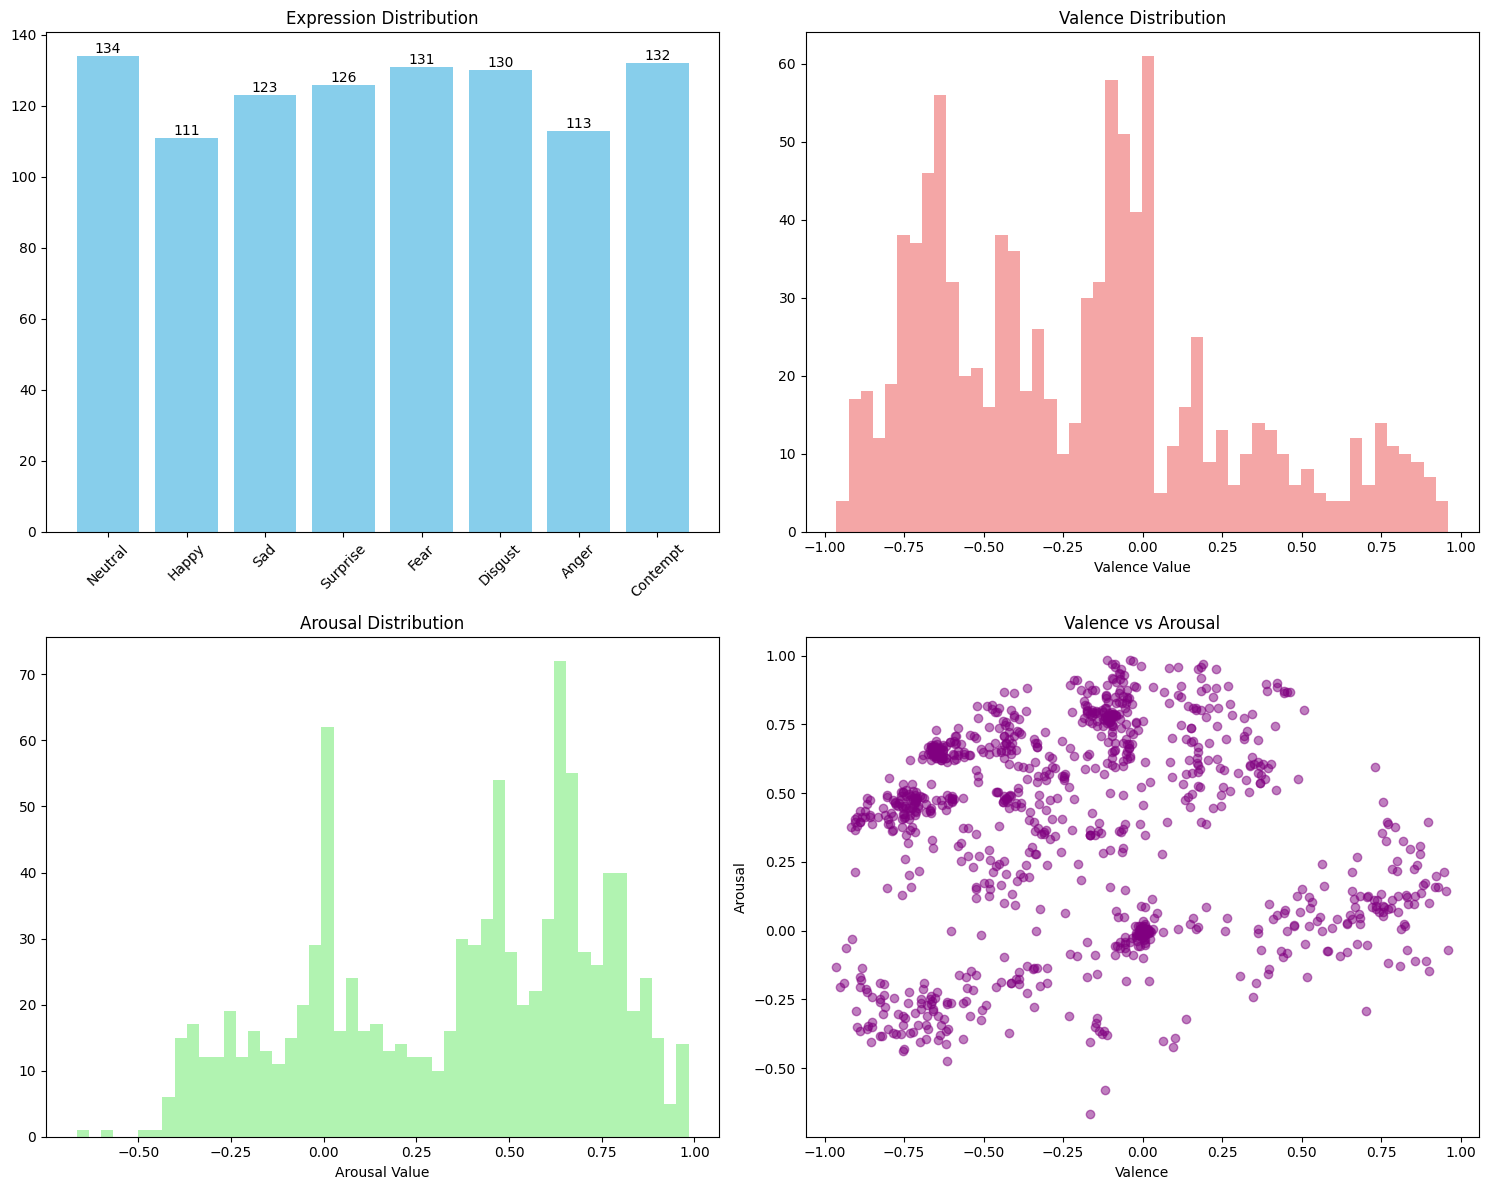

Dataset Statistics:
Total samples: 1000
Expression counts:
  Neutral: 134 (13.4%)
  Happy: 111 (11.1%)
  Sad: 123 (12.3%)
  Surprise: 126 (12.6%)
  Fear: 131 (13.1%)
  Disgust: 130 (13.0%)
  Anger: 113 (11.3%)
  Contempt: 132 (13.2%)
Valence - Min: -0.963, Max: 0.960, Mean: -0.200
Arousal - Min: -0.667, Max: 0.984, Mean: 0.360
 Splitting dataset...
 Dataset split completed:
   Training: 700 samples
   Validation: 150 samples
   Test: 150 samples
Creating ResNet50 model...
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Creating EfficientNetB0 model...
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
🔄 Creating Custom CNN model...

 PROCESSING MODEL: ResNet50
 Compiling ResNet50 model...
 Training ResNet50...
Phase 1: Feature extraction (frozen base)
Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - arousal_loss: 0.4153 - arousal_mae: 0.5142 - arousal_mse: 0.4162 - expression_accuracy: 0.1463 - expression_loss: 2.3465 - expression_sparse_top_k_categorical_accuracy: 0.6874 - loss: 

22/22 ━━━━━━━━━━━━━━━━━━━━ 155s 7s/step - arousal_loss: 0.4127 - arousal_mae: 0.5125 - arousal_mse: 0.4136 - expression_accuracy: 0.1459 - expression_loss: 2.3466 - expression_sparse_top_k_categorical_accuracy: 0.6857 - loss: 2.7886 - valence_loss: 0.4685 - valence_mae: 0.5607 - valence_mse: 0.4694 - val_arousal_loss: 0.3357 - val_arousal_mae: 0.4633 - val_arousal_mse: 0.3367 - val_expression_accuracy: 0.1067 - val_expression_loss: 2.1307 - val_expression_sparse_top_k_categorical_accuracy: 0.6200 - val_loss: 2.5666 - val_valence_loss: 0.5309 - val_valence_mae: 0.5885 - val_valence_mse: 0.5296 - learning_rate: 0.0010
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - arousal_loss: 0.3024 - arousal_mae: 0.4318 - arousal_mse: 0.3026 - expression_accuracy: 0.1677 - expression_loss: 2.2414 - expression_sparse_top_k_categorical_accuracy: 0.7077 - loss: 2.5992 - valence_loss: 0.4126 - valence_mae: 0.5105 - valence_mse: 0.4127
Epoch 2: val_expression_accuracy improved from 0.10667 to 0.13333, 

22/22 ━━━━━━━━━━━━━━━━━━━━ 216s 7s/step - arousal_loss: 0.3036 - arousal_mae: 0.4329 - arousal_mse: 0.3038 - expression_accuracy: 0.1673 - expression_loss: 2.2406 - expression_sparse_top_k_categorical_accuracy: 0.7075 - loss: 2.5989 - valence_loss: 0.4121 - valence_mae: 0.5105 - valence_mse: 0.4123 - val_arousal_loss: 0.2305 - val_arousal_mae: 0.3635 - val_arousal_mse: 0.2243 - val_expression_accuracy: 0.1333 - val_expression_loss: 2.1188 - val_expression_sparse_top_k_categorical_accuracy: 0.7000 - val_loss: 2.4850 - val_valence_loss: 0.5094 - val_valence_mae: 0.5735 - val_valence_mse: 0.5087 - learning_rate: 0.0010
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - arousal_loss: 0.3185 - arousal_mae: 0.4548 - arousal_mse: 0.3185 - expression_accuracy: 0.1626 - expression_loss: 2.2052 - expression_sparse_top_k_categorical_accuracy: 0.6759 - loss: 2.5512 - valence_loss: 0.3730 - valence_mae: 0.4856 - valence_mse: 0.3730
Epoch 3: val_expression_accuracy did not improve from 0.13333
22/22

22/22 ━━━━━━━━━━━━━━━━━━━━ 158s 7s/step - arousal_loss: 0.1973 - arousal_mae: 0.3613 - arousal_mse: 0.1973 - expression_accuracy: 0.2100 - expression_loss: 2.0432 - expression_sparse_top_k_categorical_accuracy: 0.7296 - loss: 2.2966 - valence_loss: 0.3089 - valence_mae: 0.4463 - valence_mse: 0.3089 - val_arousal_loss: 0.1642 - val_arousal_mae: 0.3217 - val_arousal_mse: 0.1693 - val_expression_accuracy: 0.1467 - val_expression_loss: 2.0843 - val_expression_sparse_top_k_categorical_accuracy: 0.6600 - val_loss: 2.2991 - val_valence_loss: 0.2453 - val_valence_mae: 0.3915 - val_valence_mse: 0.2528 - learning_rate: 0.0010
Epoch 12/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - arousal_loss: 0.1686 - arousal_mae: 0.3371 - arousal_mse: 0.1686 - expression_accuracy: 0.2082 - expression_loss: 2.0121 - expression_sparse_top_k_categorical_accuracy: 0.7558 - loss: 2.2086 - valence_loss: 0.2243 - valence_mae: 0.3790 - valence_mse: 0.2243
Epoch 12: val_expression_accuracy did not improve from 0.14667
22/

22/22 ━━━━━━━━━━━━━━━━━━━━ 146s 7s/step - arousal_loss: 0.1813 - arousal_mae: 0.3463 - arousal_mse: 0.1812 - expression_accuracy: 0.1977 - expression_loss: 2.0391 - expression_sparse_top_k_categorical_accuracy: 0.7349 - loss: 2.2574 - valence_loss: 0.2559 - valence_mae: 0.4047 - valence_mse: 0.2557 - val_arousal_loss: 0.2754 - val_arousal_mae: 0.3971 - val_arousal_mse: 0.2666 - val_expression_accuracy: 0.1600 - val_expression_loss: 2.1128 - val_expression_sparse_top_k_categorical_accuracy: 0.6467 - val_loss: 2.3673 - val_valence_loss: 0.2496 - val_valence_mae: 0.3935 - val_valence_mse: 0.2489 - learning_rate: 0.0010
Epoch 14/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - arousal_loss: 0.1889 - arousal_mae: 0.3627 - arousal_mse: 0.1888 - expression_accuracy: 0.2453 - expression_loss: 1.9826 - expression_sparse_top_k_categorical_accuracy: 0.7646 - loss: 2.2004 - valence_loss: 0.2471 - valence_mae: 0.3999 - valence_mse: 0.2470
Epoch 14: val_expression_accuracy did not improve from 0.16000
22/

22/22 ━━━━━━━━━━━━━━━━━━━━ 143s 6s/step - arousal_loss: 0.1690 - arousal_mae: 0.3450 - arousal_mse: 0.1686 - expression_accuracy: 0.2585 - expression_loss: 1.9529 - expression_sparse_top_k_categorical_accuracy: 0.7740 - loss: 2.1666 - valence_loss: 0.2564 - valence_mae: 0.4162 - valence_mse: 0.2574 - val_arousal_loss: 0.1813 - val_arousal_mae: 0.3285 - val_arousal_mse: 0.1825 - val_expression_accuracy: 0.1800 - val_expression_loss: 2.1154 - val_expression_sparse_top_k_categorical_accuracy: 0.6667 - val_loss: 2.2958 - val_valence_loss: 0.1815 - val_valence_mae: 0.3384 - val_valence_mse: 0.1866 - learning_rate: 5.0000e-04
Epoch 20/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - arousal_loss: 0.1612 - arousal_mae: 0.3392 - arousal_mse: 0.1612 - expression_accuracy: 0.2955 - expression_loss: 1.9113 - expression_sparse_top_k_categorical_accuracy: 0.8329 - loss: 2.0992 - valence_loss: 0.2168 - valence_mae: 0.3830 - valence_mse: 0.2166
Epoch 20: val_expression_accuracy did not improve from 0.18000

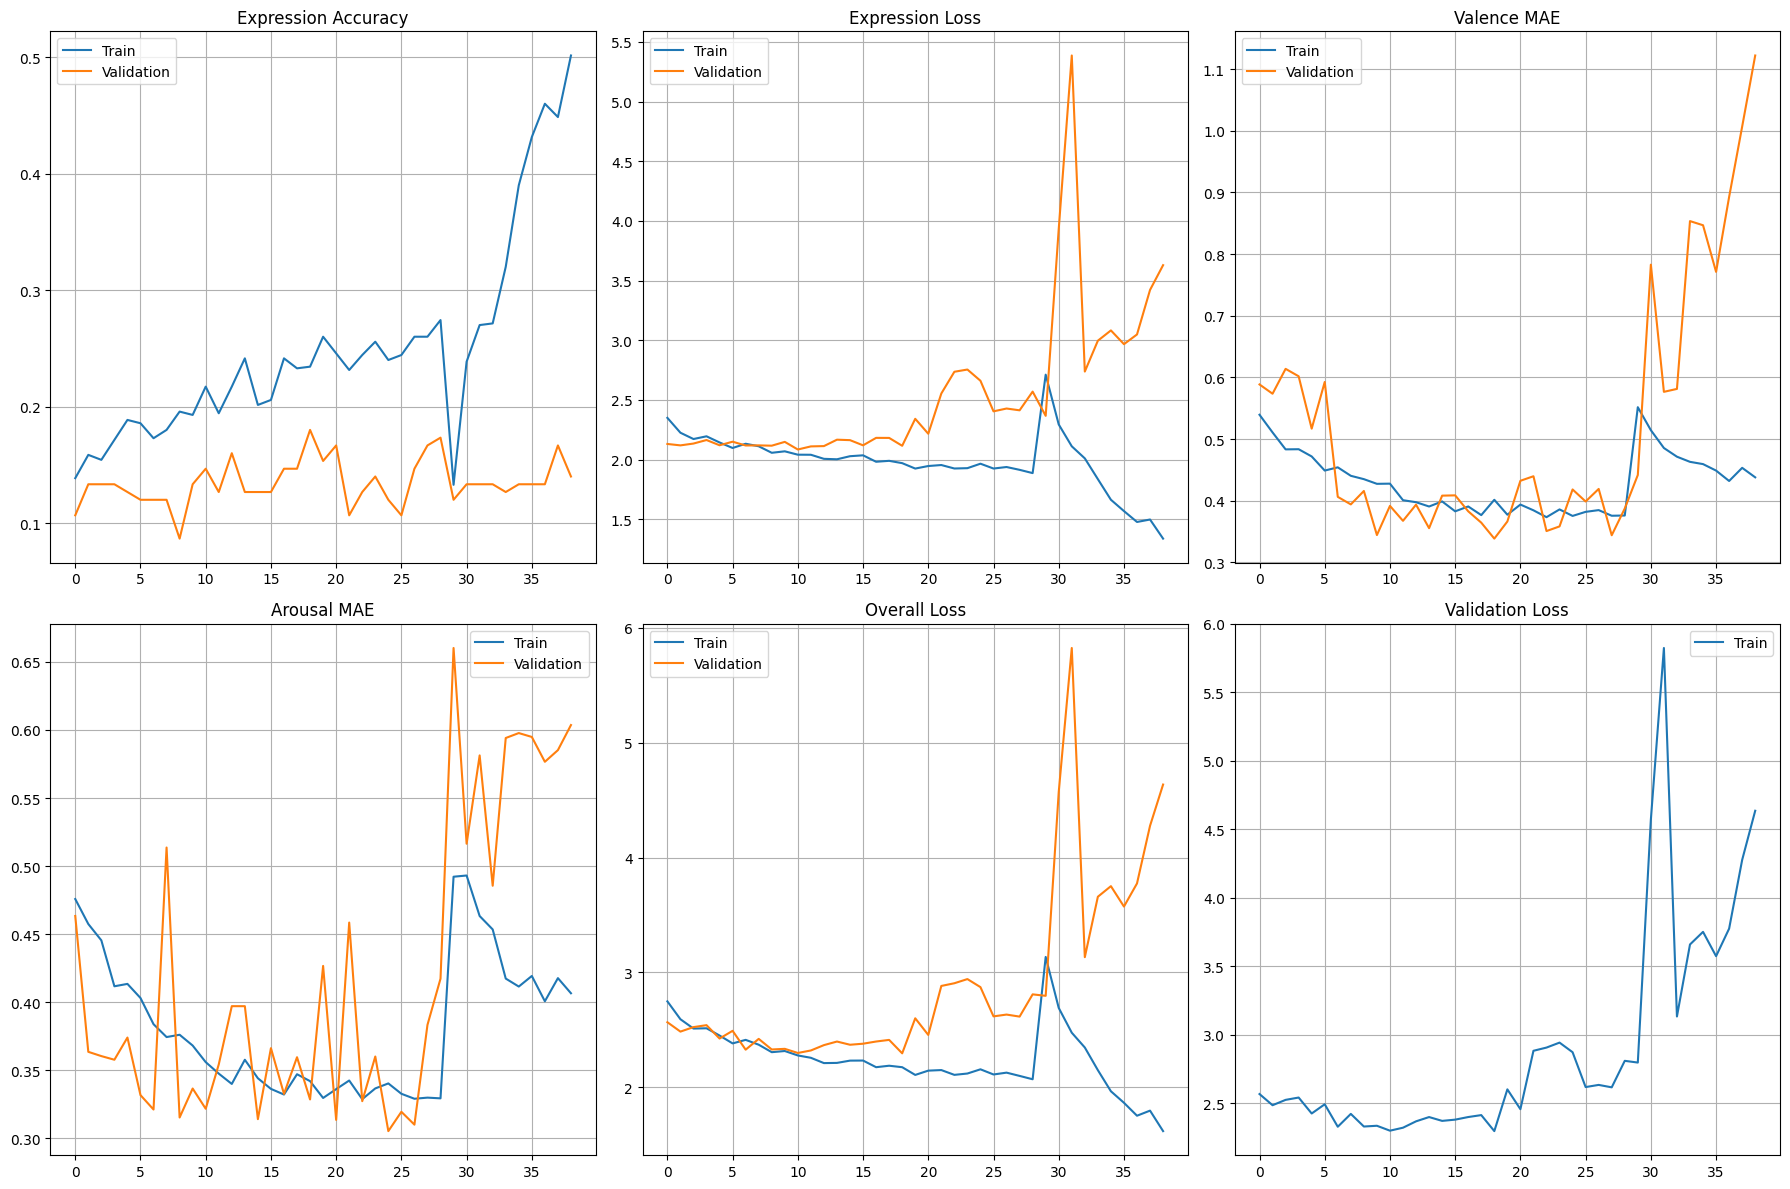

 Evaluating model...


NameError: name 'mean_squared_error' is not defined

In [9]:
def main_pipeline():
    """
    MAIN PIPELINE EXECUTION
    Run this cell to execute the complete pipeline
    """
    print(" STARTING AFFECT RECOGNITION PIPELINE")
    print("="*60)

    # Step 1: Load data
    file_groups = data_loader.load_annotation_groups(config.MAX_SAMPLES)
    samples = data_loader.parse_samples(file_groups)

    if not samples:
        print(" No valid samples found! Check dataset path.")
        return

    X, expressions, valence, arousal = data_loader.load_images(samples)

    # Step 2: Analyze and split data
    analyzer.analyze_dataset(expressions, valence, arousal)

    splits = analyzer.split_dataset(X, expressions, valence, arousal,
                                  config.TEST_SPLIT, config.VALIDATION_SPLIT)

    X_train, X_val, X_test, expr_train, expr_val, expr_test, \
    valence_train, valence_val, valence_test, arousal_train, arousal_val, arousal_test = splits

    # Step 3: Create data generators
    train_gen = AdvancedDataGenerator(
        X_train,
        (expr_train, valence_train, arousal_train),
        batch_size=config.BATCH_SIZE,
        augment=True
    )

    val_gen = AdvancedDataGenerator(
        X_val,
        (expr_val, valence_val, arousal_val),
        batch_size=config.BATCH_SIZE,
        augment=False
    )

    # Step 4: Define models to train
    models_to_train = {
        'ResNet50': model_factory.create_resnet50(fine_tune=False),
        'EfficientNetB0': model_factory.create_efficientnet(fine_tune=False),
        'CustomCNN': model_factory.create_custom_cnn()
    }

    # Step 5: Train and evaluate models
    results_dict = {}
    predictions_dict = {}

    for name, model in models_to_train.items():
        print(f"\n{'='*60}")
        print(f" PROCESSING MODEL: {name}")
        print(f"{'='*60}")

        # Train model
        trainer = ModelTrainer(model, name)
        trainer.compile_model()
        trainer.train(train_gen, val_gen, config.EPOCHS, config.FINE_TUNE_EPOCHS)
        trainer.plot_training_history()

        # Evaluate model
        y_test = (expr_test, valence_test, arousal_test)
        results, predictions = evaluator.evaluate_model(model, X_test, y_test)
        results_dict[name] = results
        predictions_dict[name] = predictions

        # Plot confusion matrix
        evaluator.plot_confusion_matrix(expr_test, predictions[0], name)

        # Save model
        model.save(f'{name}_affect_model.h5')
        print(f"💾 Model saved as '{name}_affect_model.h5'")

    # Step 6: Compare models
    print(f"\n{'='*60}")
    print(f"MODEL COMPARISON RESULTS")
    print(f"{'='*60}")

    comparison_df = evaluator.compare_models(results_dict)
    print(comparison_df)

    # Save results
    comparison_df.to_csv('model_comparison_results.csv')
    results_summary = {
        'config': vars(config),
        'results': results_dict
    }

    print(f"\n Pipeline completed successfully!")
    print(f" Results saved to 'model_comparison_results.csv'")

    return comparison_df, results_dict, predictions_dict

# Execute the pipeline
if __name__ == "__main__":
    results_df, results_dict, predictions_dict = main_pipeline()

In [13]:
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K

# Define mse function manually
def mse(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=-1)

model = load_model('best_ResNet50.h5', custom_objects={'mse': mse})


In [14]:
from tensorflow.keras.models import load_model

model = load_model('best_ResNet50.h5', compile=False)